In [1]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
import json
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

plt.style.use("ggplot")
FIGSIZE = (13, 8)
DPI = 300

In [2]:
summary_files = list(Path("../../results/novel/assessment/").rglob("*.json"))

In [3]:
data = []
columns = ["sample", "tech", "precision", "recall", "FN", "FP", "TP", "CSI"]
for p in summary_files:
    d = json.loads(p.read_text())
    sample = p.parts[-2]
    tech = p.parts[-4]

    precision = float(d["Precision"]["Precision_edit_dist"])
    fps = int(d["Precision"]["FP"]["Count"])
    recall = float(d["Recall"]["Recall_edit_dist"])
    fns = int(d["Recall"]["FN"]["Count"])
    tps = int(d["Recall"]["TP"]["Count"])
    try:
        csi = tps/(tps+fps+fns)
    except ZeroDivisionError:
        csi=None
    data.append((sample, tech, precision, recall, fns, fps, tps, csi))
df = pd.DataFrame(data, columns=columns)

In [4]:
df

,sample,tech,precision,recall,FN,FP,TP,CSI
0,18_0622312,illumina,0.0,0.000000,0,0,0,NaN
1,18_0622465,illumina,0.0,0.750000,1,2,3,0.500000
2,18_0622267,illumina,0.0,0.875000,1,6,7,0.500000
3,18_0622431,illumina,0.0,0.750000,2,6,6,0.428571
4,18_0622455,illumina,0.0,1.000000,0,3,4,0.571429
...,...,...,...,...,...,...,...,...
295,mada_1-41,nanopore,0.0,0.500000,2,2,2,0.333333
296,mada_1-46,nanopore,0.0,0.666667,2,4,4,0.400000
297,mada_2-50,nanopore,0.5,1.000000,0,2,1,0.333333
298,mada_154,nanopore,0.0,1.000000,0,1,1,0.500000


In [14]:
counts = df.drop(columns=["recall", "precision", "CSI"]).melt(id_vars=["sample", "tech"], var_name="classification", value_name="count")
counts

,sample,tech,classification,count
0,18_0622312,illumina,FN,0
1,18_0622465,illumina,FN,1
2,18_0622267,illumina,FN,1
3,18_0622431,illumina,FN,2
4,18_0622455,illumina,FN,0
...,...,...,...,...
895,mada_1-41,nanopore,TP,2
896,mada_1-46,nanopore,TP,4
897,mada_2-50,nanopore,TP,1
898,mada_154,nanopore,TP,1


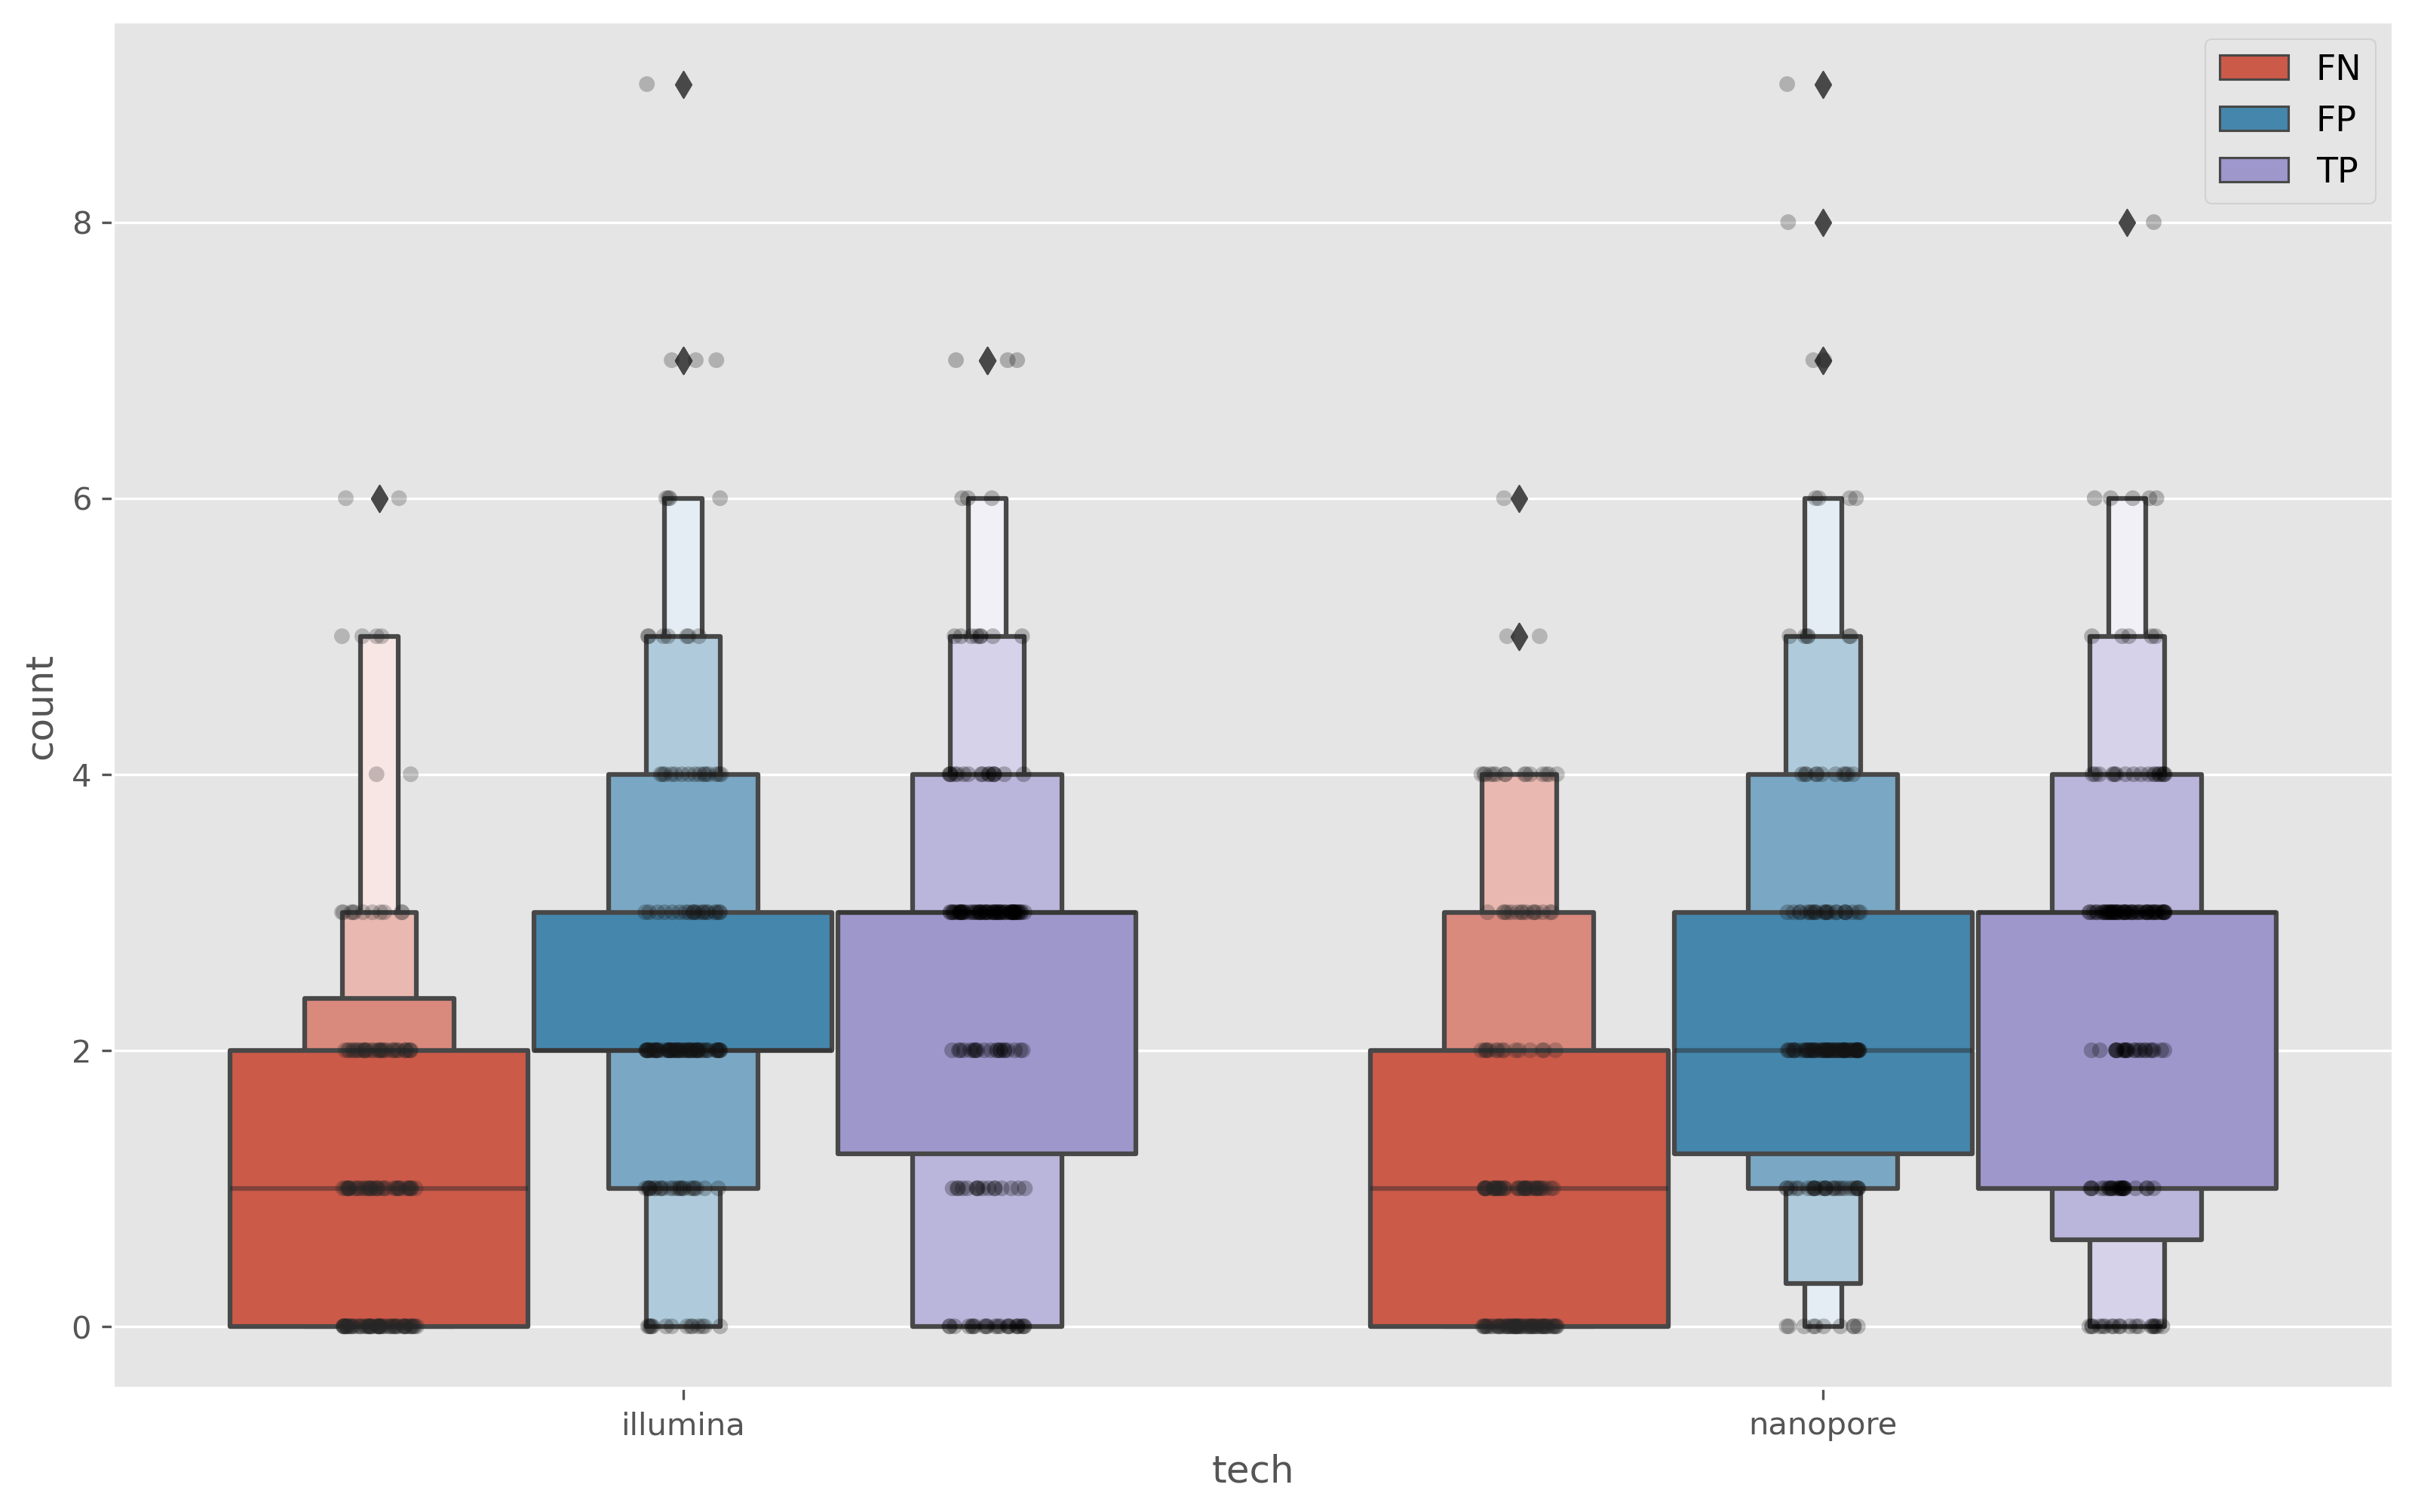

In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
x = "tech"
y = "count"
hue = "classification"
sns.boxenplot(data=counts, x=x, y=y, hue=hue, )
sns.stripplot(data=counts, x=x, y=y, hue=hue, dodge=True, jitter=True, color="black", alpha=0.25)

leghandles, leglabels = ax.get_legend_handles_labels()
ax.legend(leghandles[:-3], leglabels[:-3], loc="best", prop={"size": 11})

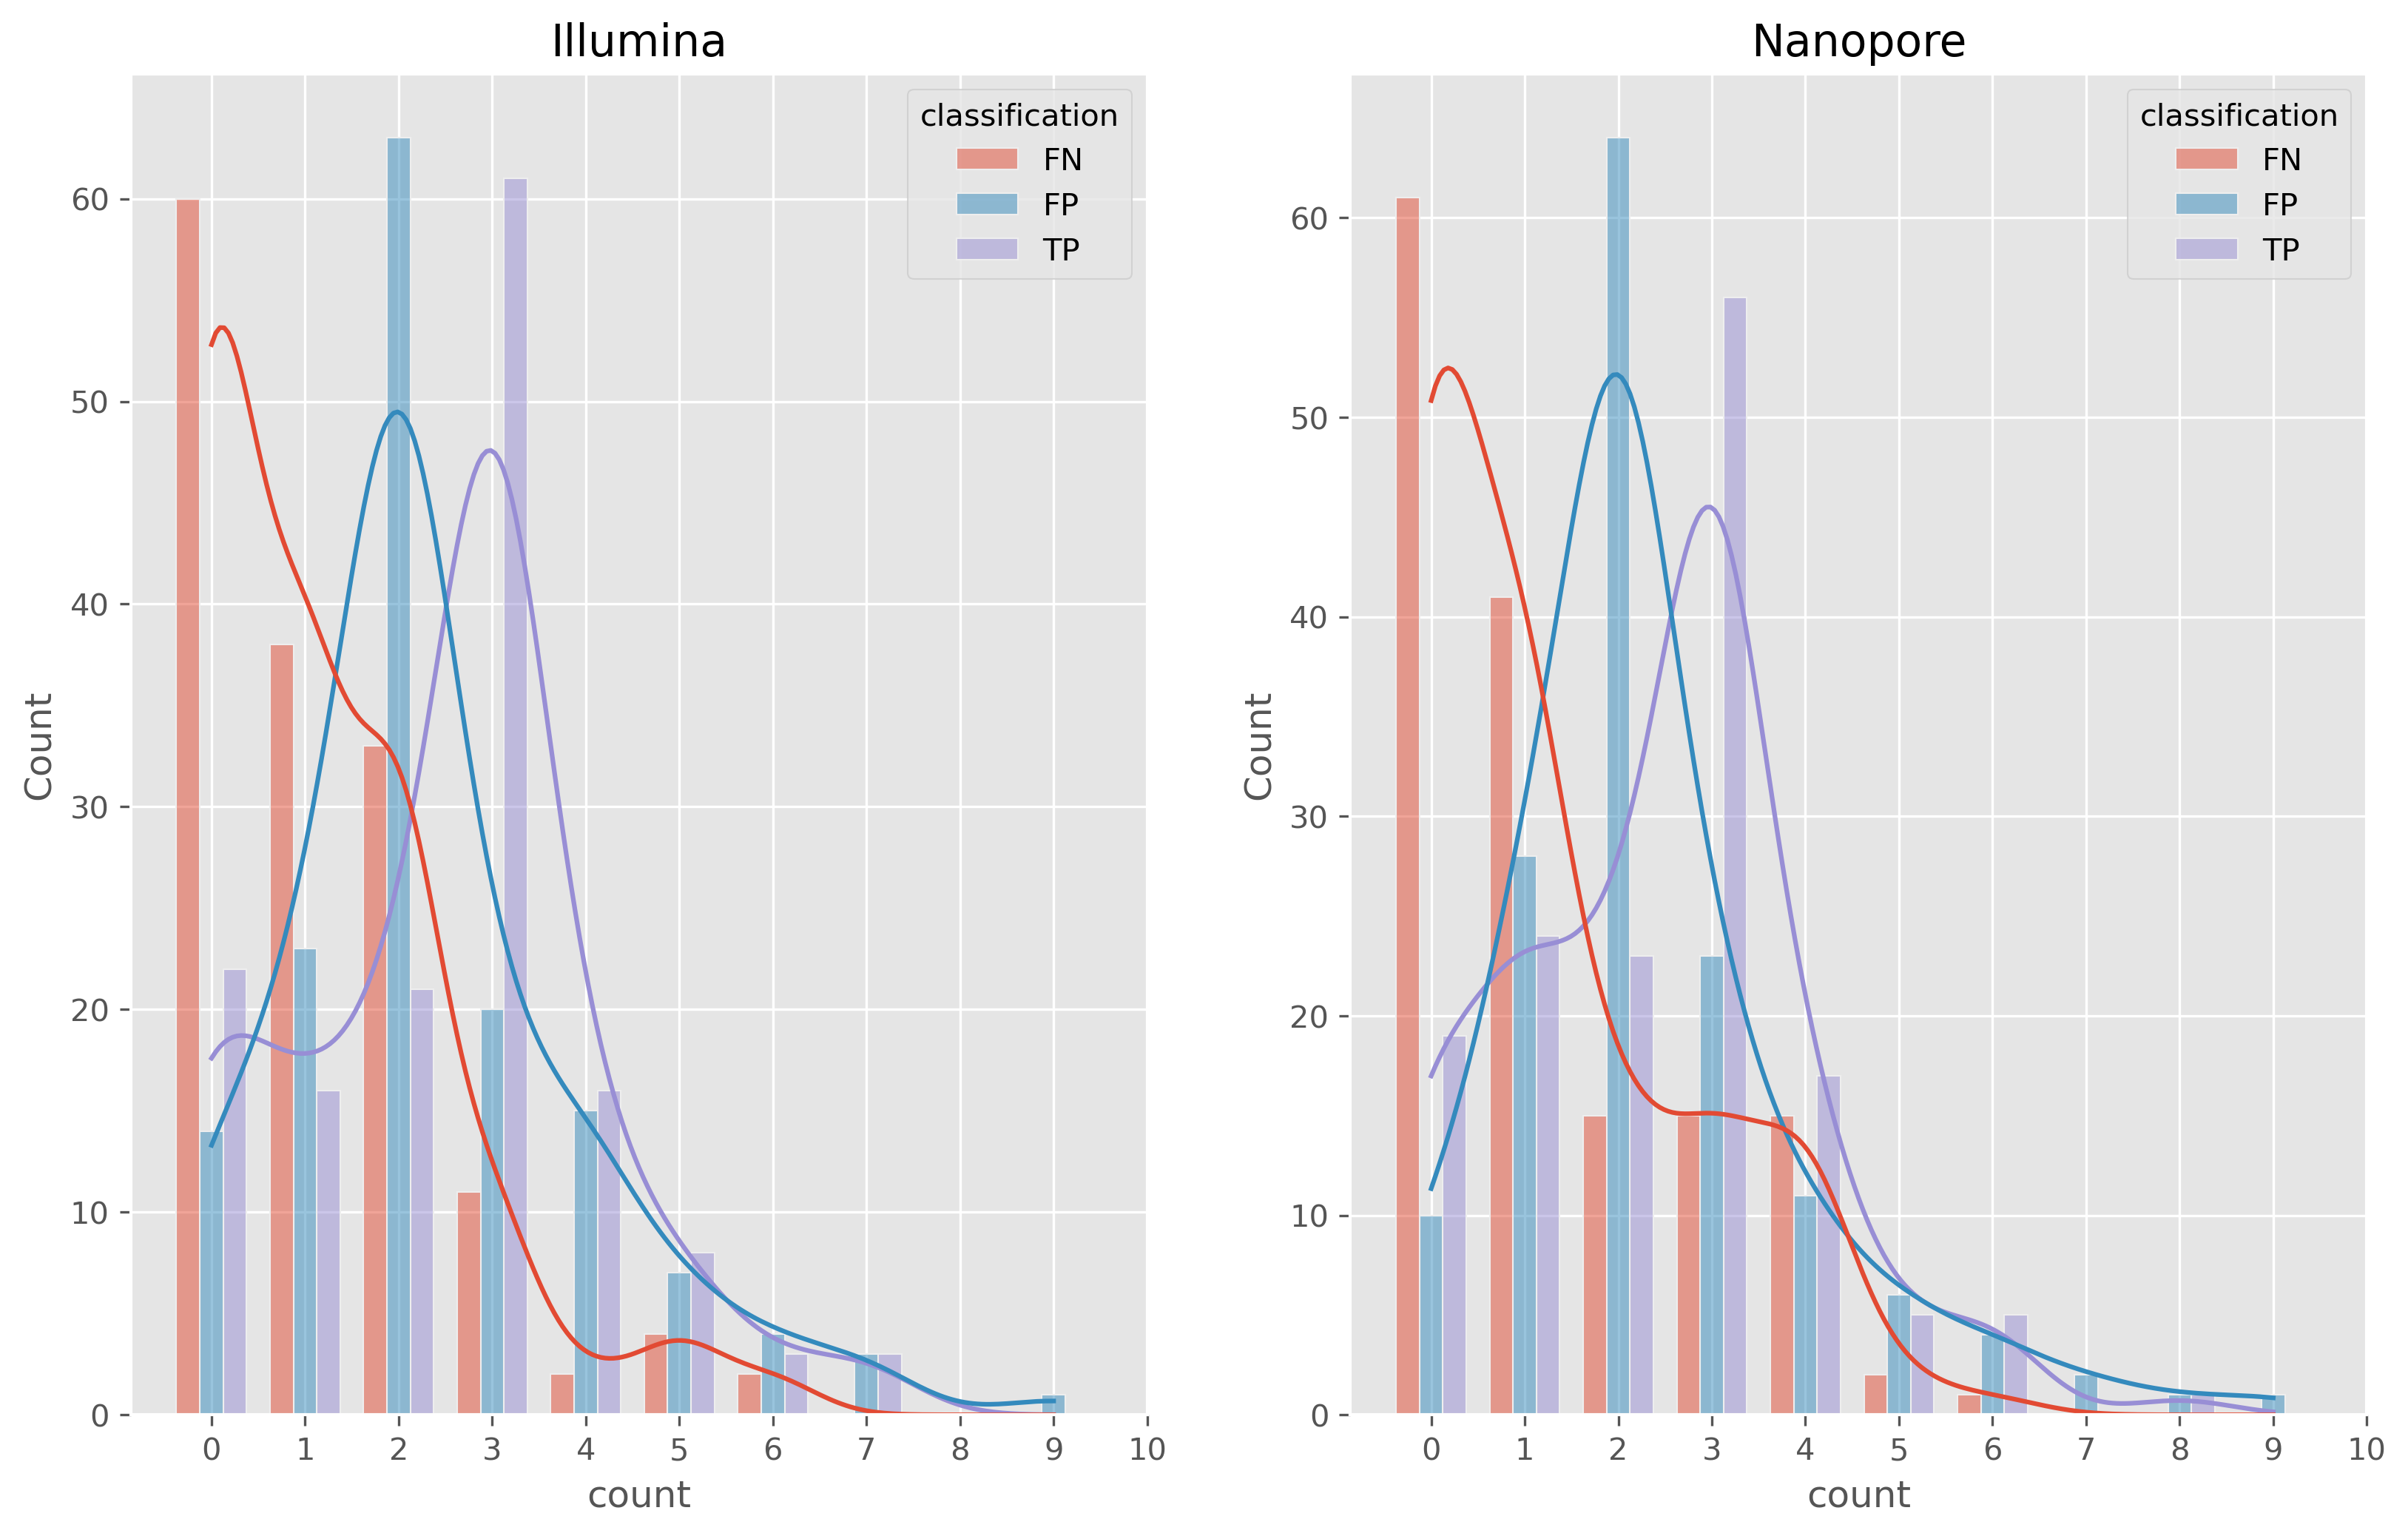

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    x = "count"
    hue = "classification"
    sns.histplot(
        data=counts.query("tech == @tech"), 
        x=x, 
        hue=hue, 
        ax=ax, 
        stat="count", 
        multiple="dodge", 
        discrete=True,
        kde=True,
        shrink=0.75
    )
    ax.set_title(f"{tech.capitalize()}")
    ax.set_xticks(range(11))

<AxesSubplot:xlabel='tech', ylabel='CSI'>

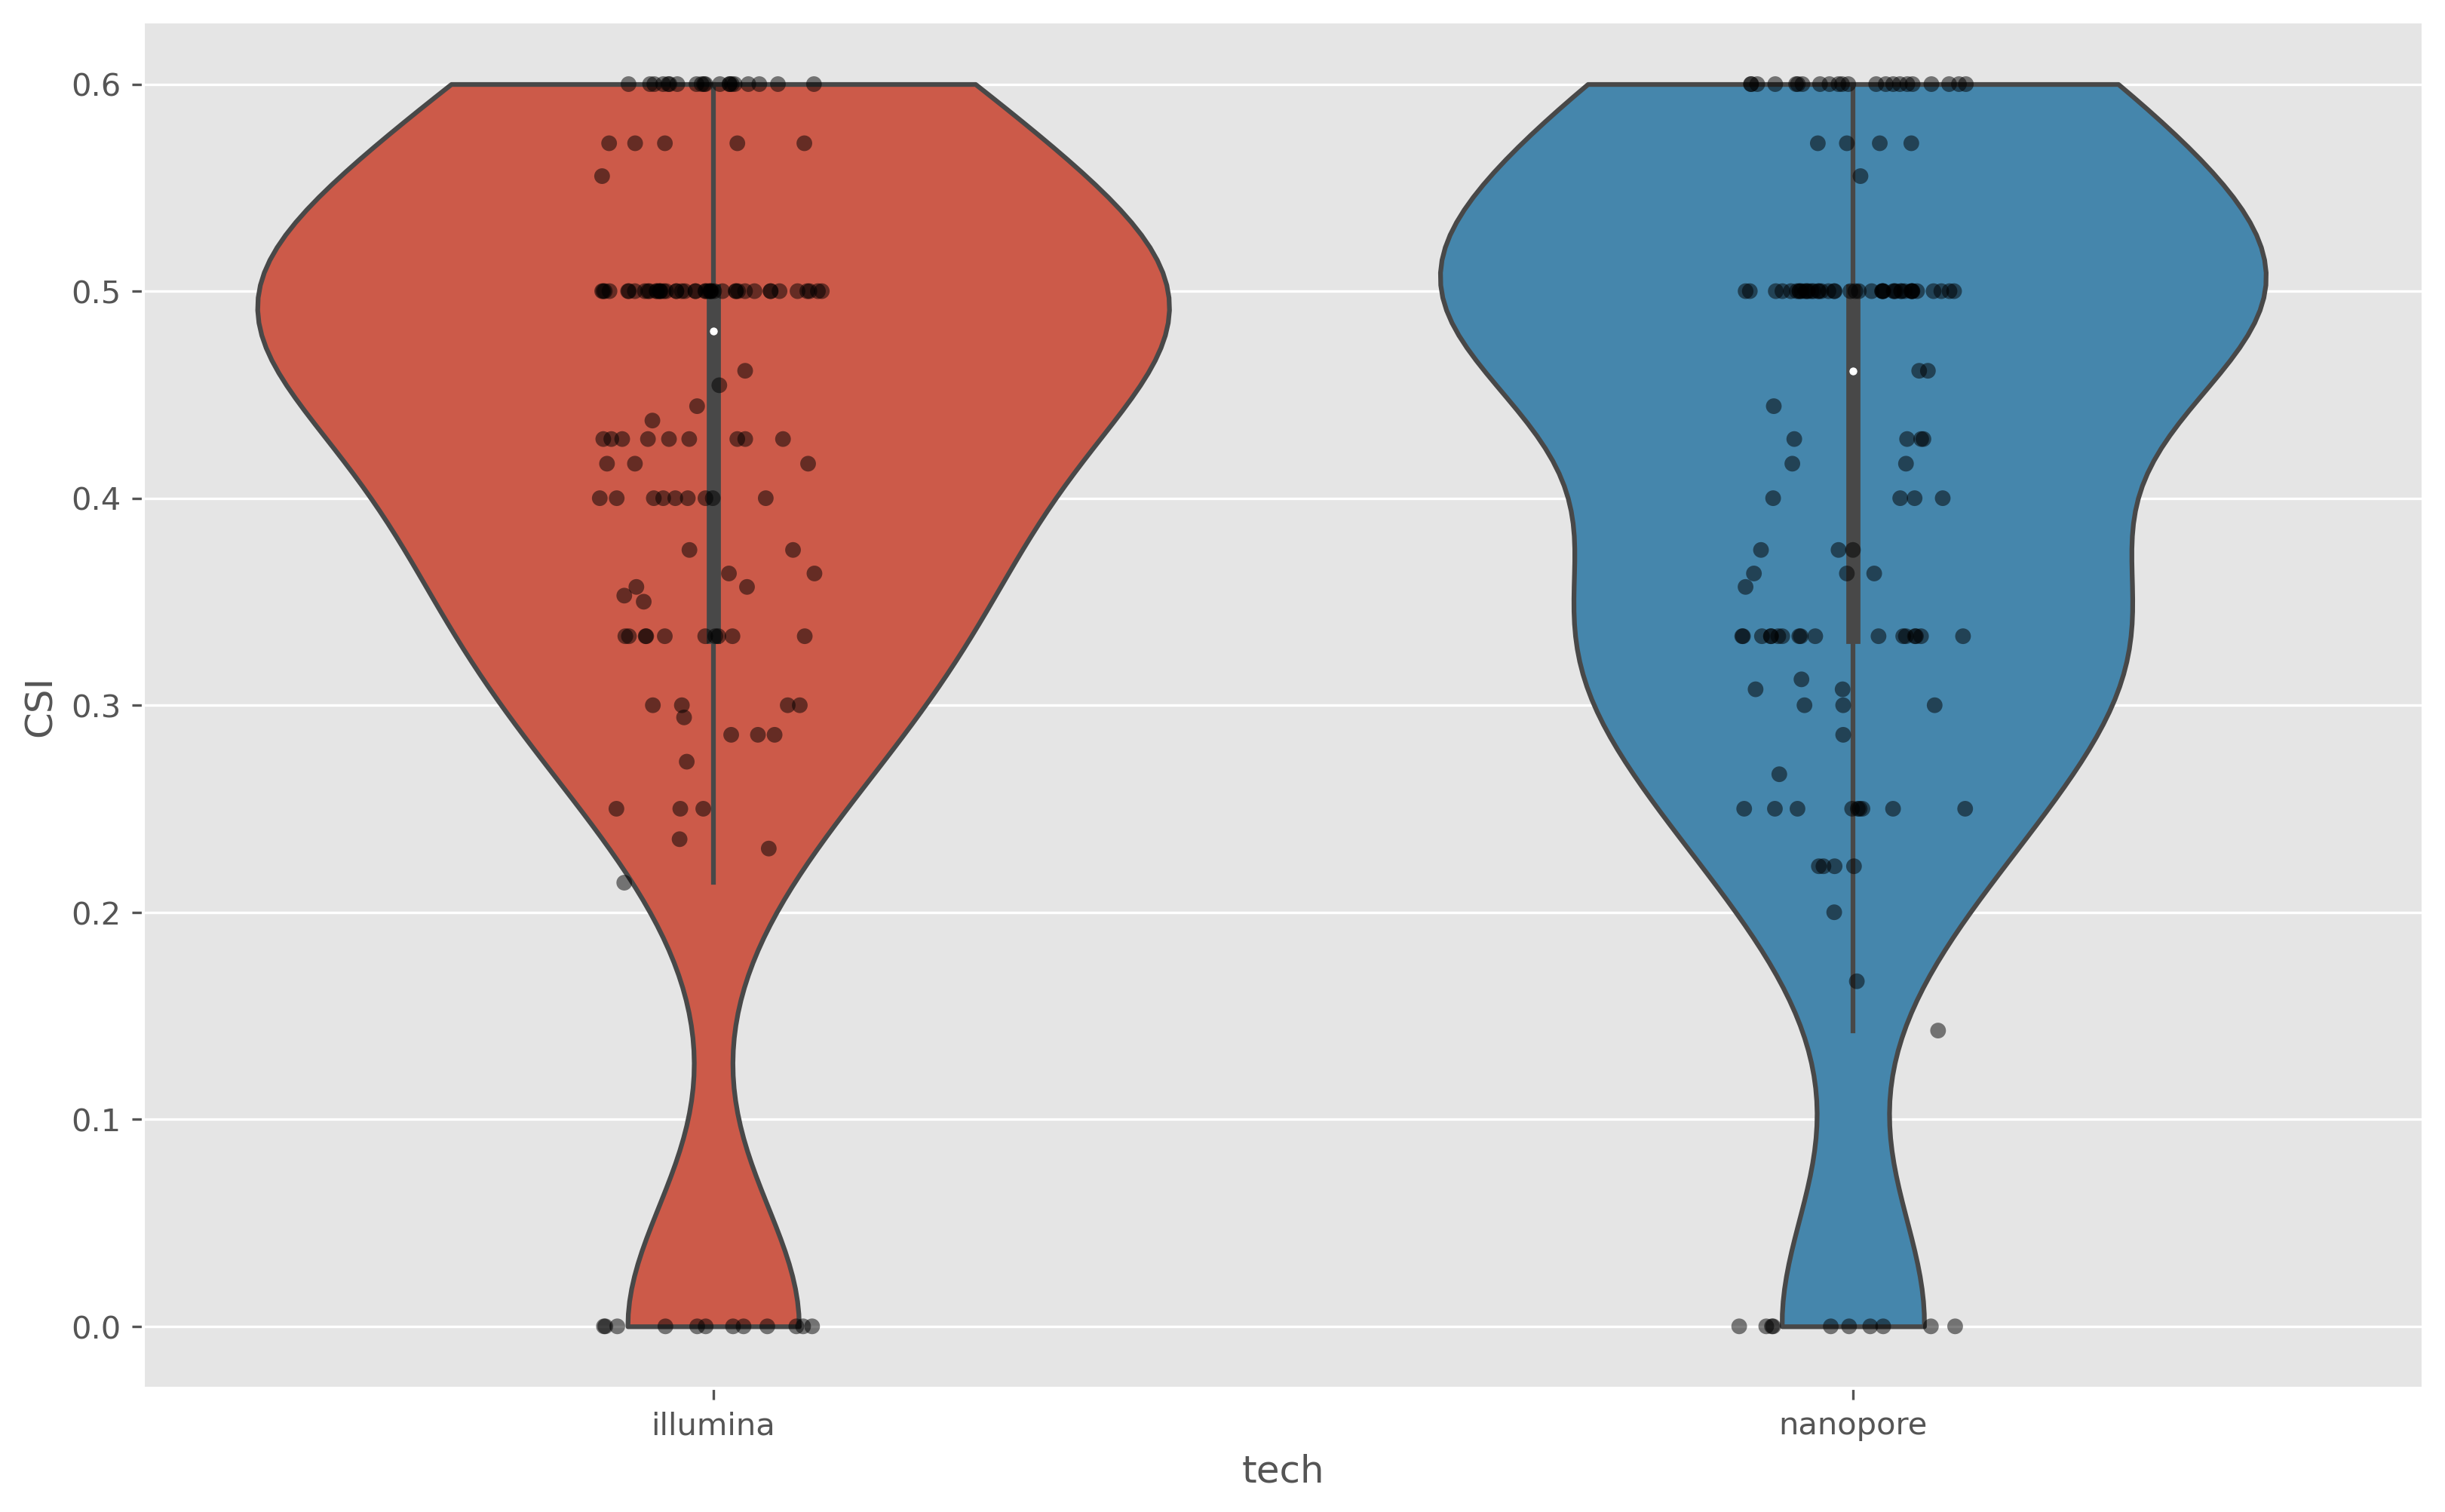

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=FIGSIZE, dpi=DPI)
sns.violinplot(data=df, x="tech", y="CSI", cut=0)
sns.stripplot(data=df, x="tech", y="CSI", color="black", alpha=0.5)

In [18]:
df.groupby(["tech"]).describe().T

tech               illumina    nanopore
precision count  150.000000  150.000000
          mean     0.000000    0.003333
          std      0.000000    0.040825
          min      0.000000    0.000000
          25%      0.000000    0.000000
          50%      0.000000    0.000000
          75%      0.000000    0.000000
          max      0.000000    0.500000
recall    count  150.000000  150.000000
          mean     0.657990    0.647239
          std      0.334080    0.334634
          min      0.000000    0.000000
          25%      0.500000    0.500000
          50%      0.714286    0.750000
          75%      1.000000    1.000000
          max      1.000000    1.000000
FN        count  150.000000  150.000000
          mean     1.180000    1.280000
          std      1.331447    1.456851
          min      0.000000    0.000000
          25%      0.000000    0.000000
          50%      1.000000    1.000000
          75%      2.000000    2.000000
          max      6.000000    6.000000
FP        count  150.000000  150.000000
          mean     2.386667    2.360000
          std      1.612812    1.572755
          min      0.000000    0.000000
          25%      2.000000    1.250000
          50%      2.000000    2.000000
          75%      3.000000    3.000000
          max      9.000000    9.000000
TP        count  150.000000  150.000000
          mean     2.560000    2.460000
          std      1.590576    1.539764
          min      0.000000    0.000000
          25%      1.250000    1.000000
          50%      3.000000    3.000000
          75%      3.000000    3.000000
          max      7.000000    8.000000
CSI       count  140.000000  141.000000
          mean     0.415715    0.406559
          std      0.161734    0.162949
          min      0.000000    0.000000
          25%      0.333333    0.333333
          50%      0.480769    0.461538
          75%      0.500000    0.500000
          max      0.600000    0.600000

In [19]:
from cyvcf2 import VCF

In [32]:
columns = ["sample", "tech", "gene", "classification", "count", "is_indel"]

In [33]:
data = []
clf_tag = "VFR_RESULT"
for p in Path("../../results/novel/").rglob("recall.vcf"):
    sample = p.parts[-3]
    tech = p.parts[-5]
    for v in VCF(p):
        gene = v.CHROM
        clf = v.format(clf_tag)[0]
        if "FP" in clf:
            clf = "FN"
        if "TP" in clf:
            clf = "TP"
        data.append((sample, tech, gene, clf, 1))

for p in Path("../../results/novel/").rglob("precision.vcf"):
    sample = p.parts[-2]
    tech = p.parts[-4]
    for v in VCF(p):
        gene = v.CHROM
        clf = v.format(clf_tag)[0]
        if "FP" in clf:
            clf = "FP"
        if "TP" in clf:
            clf="TP"
        data.append((sample, tech, gene, clf, 1))

[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not su

[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
[W::bcf_hdr_register_hrec] The type "None" is not su

TypeError: 'bool' object is not callable

In [34]:
df = pd.DataFrame(data, columns=columns)

In [35]:
df

,sample,tech,gene,classification,count,is_indel
0,18_0622465,illumina,rpoB,TP,1,False
1,18_0622465,illumina,embA,TP,1,False
2,18_0622465,illumina,gid,TP,1,False
3,18_0622465,illumina,rrs,FN,1,False
4,18_0622267,illumina,rpoB,TP,1,False
...,...,...,...,...,...,...
1117,mada_1-48,nanopore,rpoB,TP,1,False
1118,mada_1-48,nanopore,gid,TP,1,False
1119,mada_1-48,nanopore,gid,FN,1,False
1120,mada_1-48,nanopore,gyrA,FN,1,False


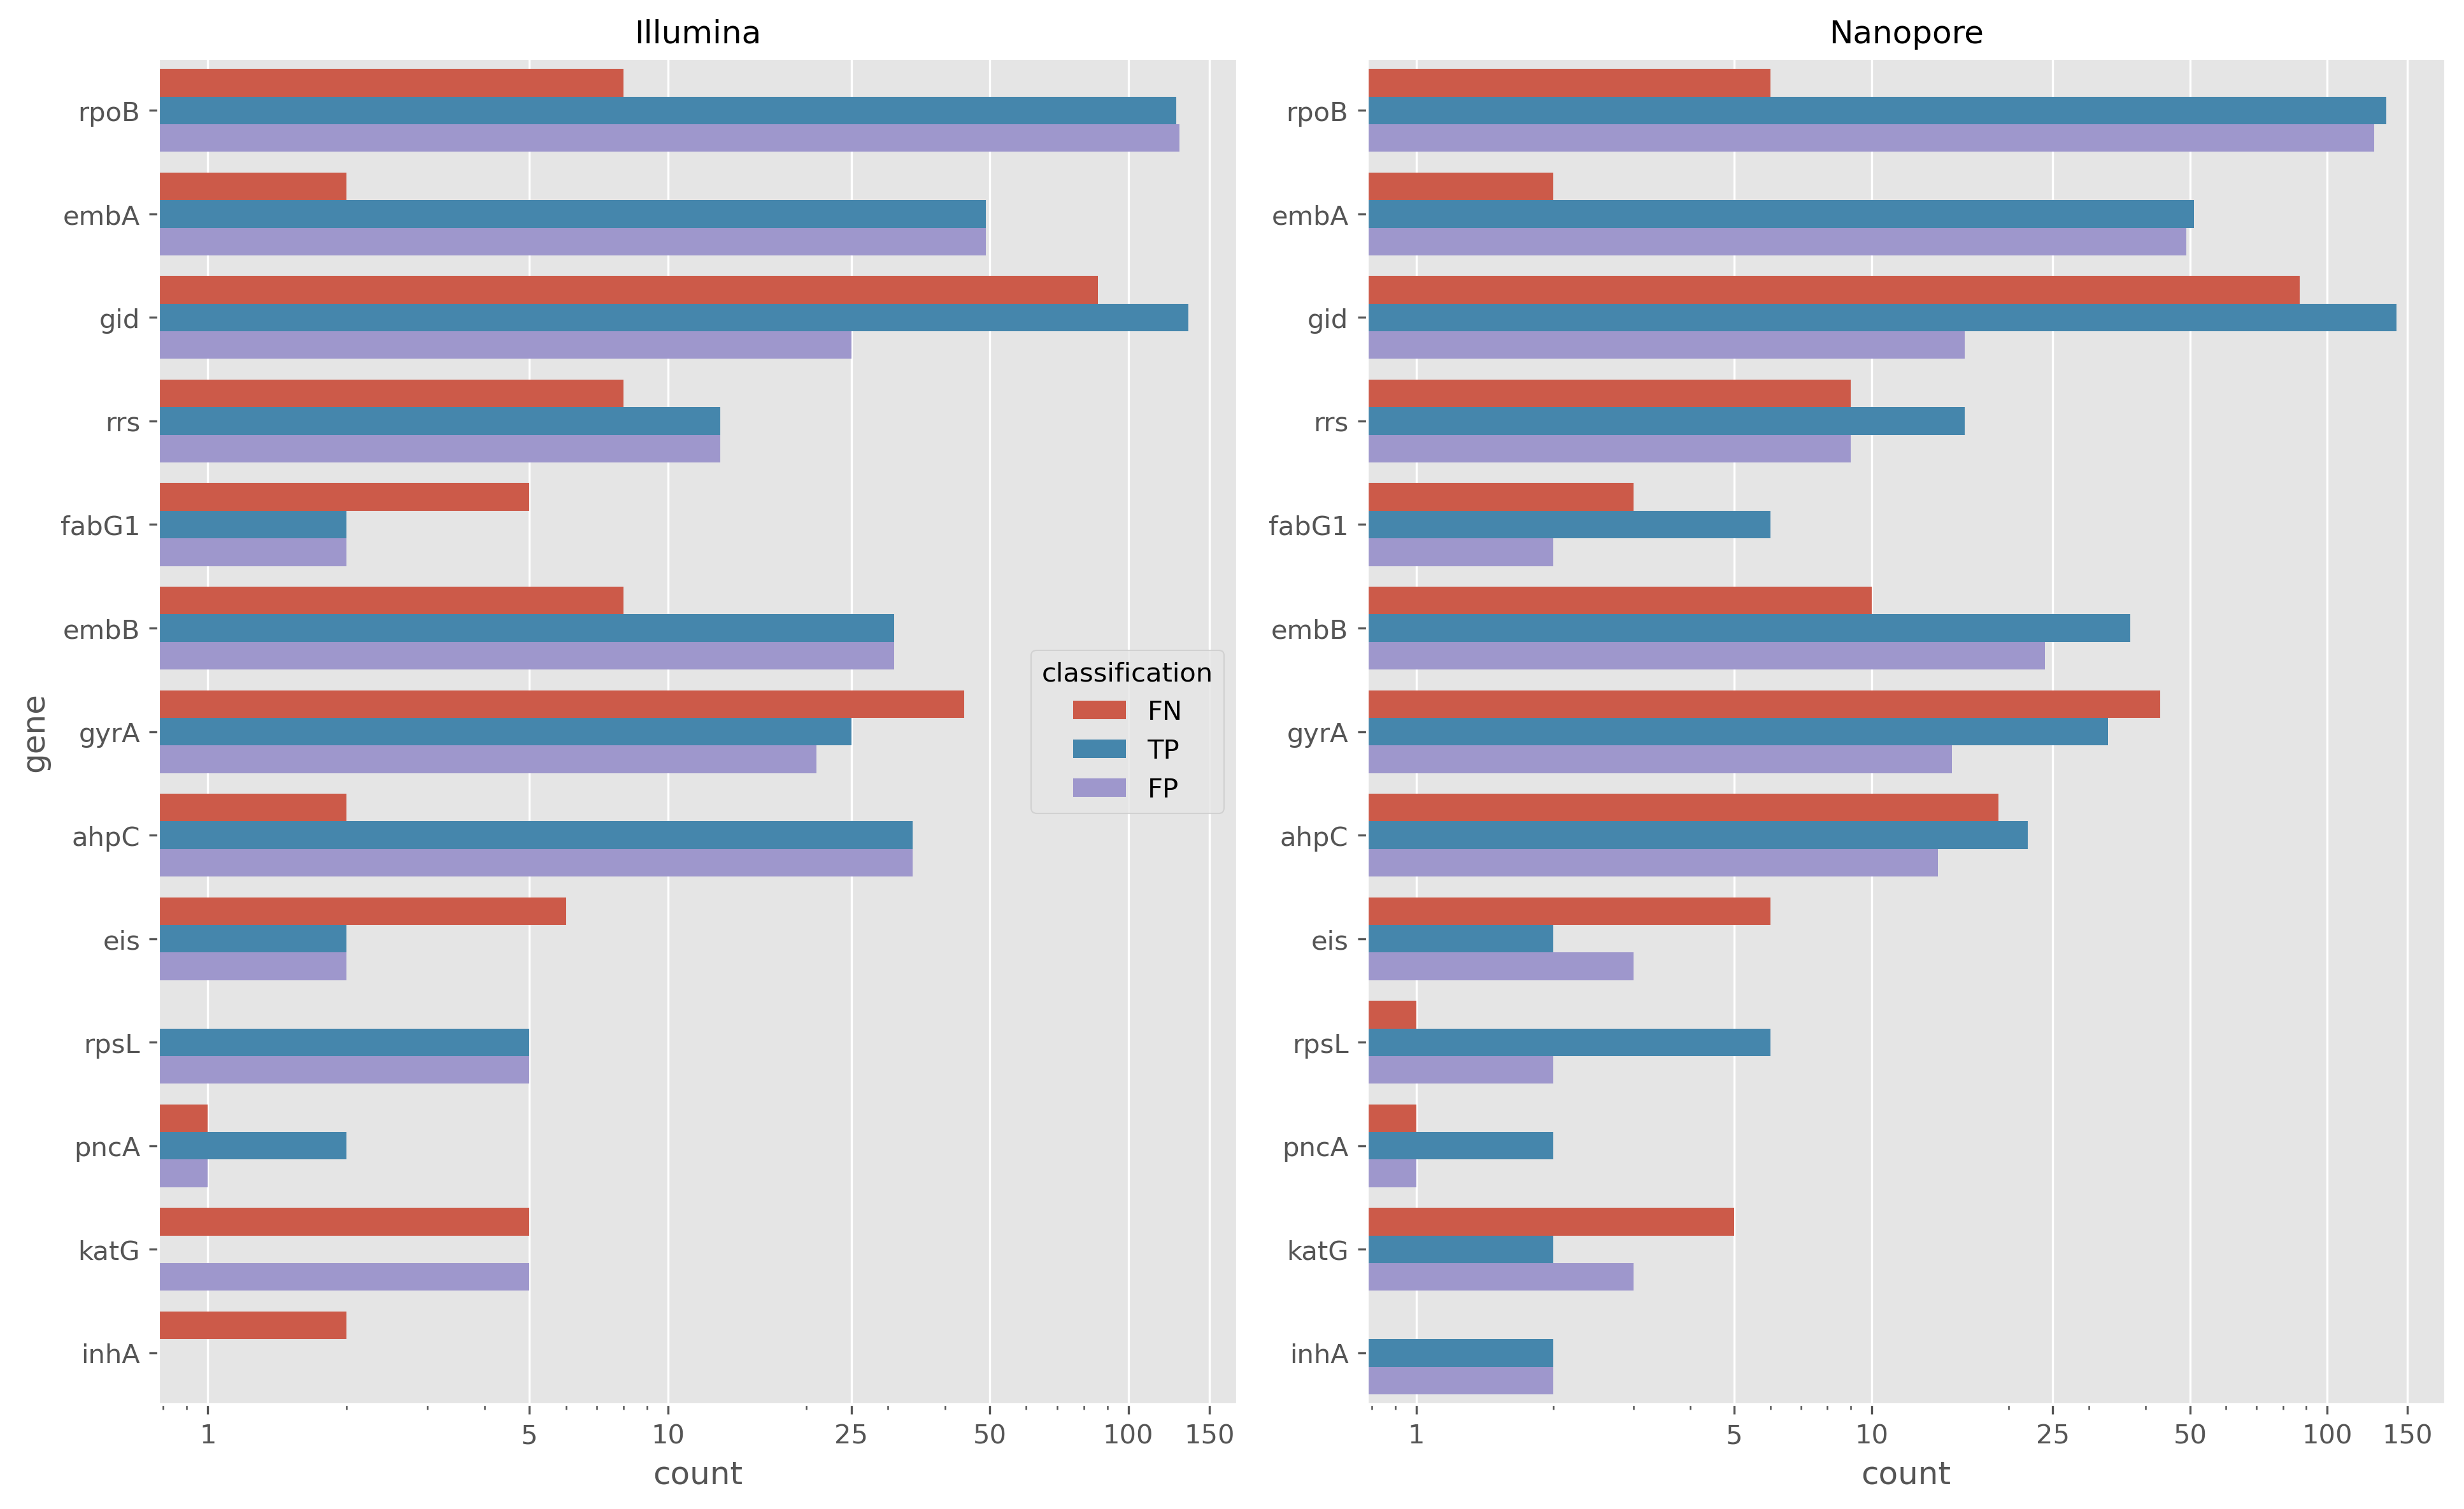

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.countplot(data=df.query("tech==@tech"), hue="classification", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
    ax.set_xscale("log")
    labels = [1, 5, 10, 25, 50, 100, 150]
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

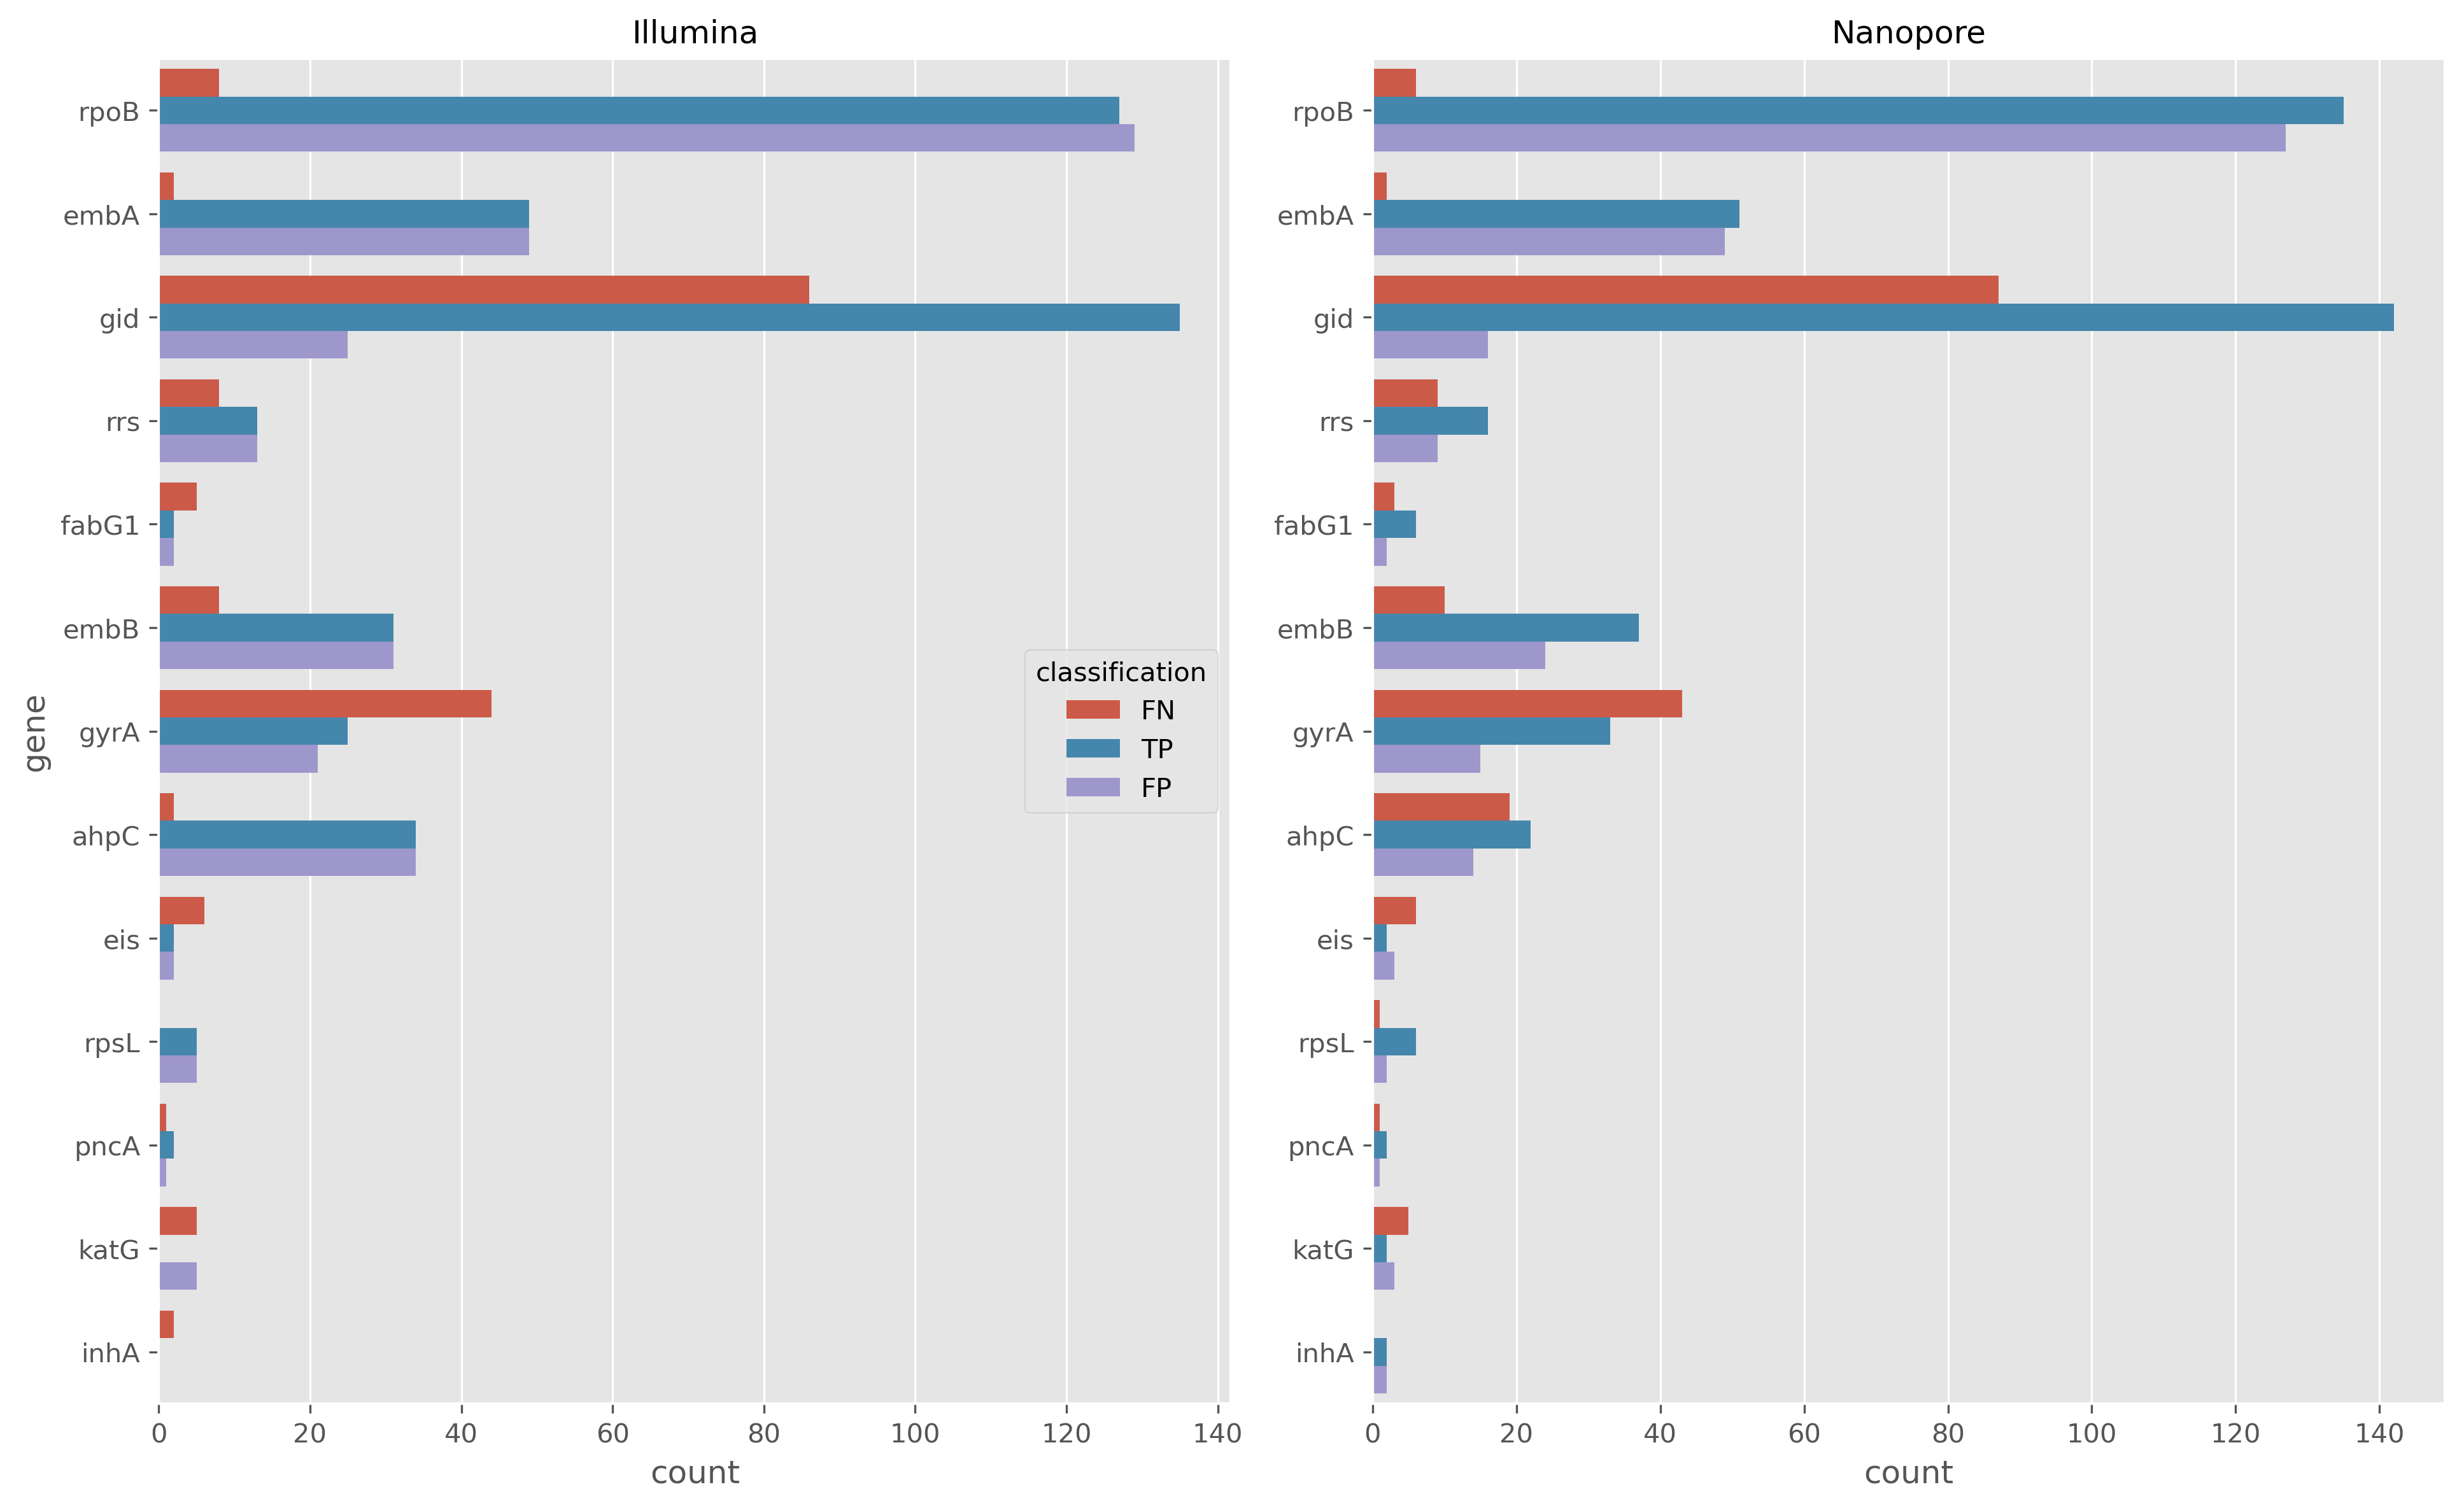

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.countplot(data=df.query("tech==@tech"), hue="classification", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
    
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [27]:
# df["count"] = 1
g = df.groupby(["sample", "tech", "gene", "classification"]).count().reset_index()

In [28]:
g.groupby(["tech", "gene", "classification"]).describe()

count                                          \
                             count      mean       std  min  25%  50%  75%   
tech     gene classification                                                 
illumina ahpC FN               2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
              FP              34.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
              TP              34.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
         eis  FN               6.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
              FP               2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
...                            ...       ...       ...  ...  ...  ...  ...   
nanopore rpsL FP               2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
              TP               4.0  1.500000  0.577350  1.0  1.0  1.5  2.0   
         rrs  FN               8.0  1.125000  0.353553  1.0  1.0  1.0  1.0   
              FP               9.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
              TP              12.0  1.333333  0.492366  1.0  1.0  1.0  2.0   

                                   
                              max  
tech     gene classification       
illumina ahpC FN              1.0  
              FP              1.0  
              TP              1.0  
         eis  FN              1.0  
              FP              1.0  
...                           ...  
nanopore rpsL FP              1.0  
              TP              2.0  
         rrs  FN              2.0  
              FP              1.0  
              TP              2.0  

[73 rows x 8 columns]

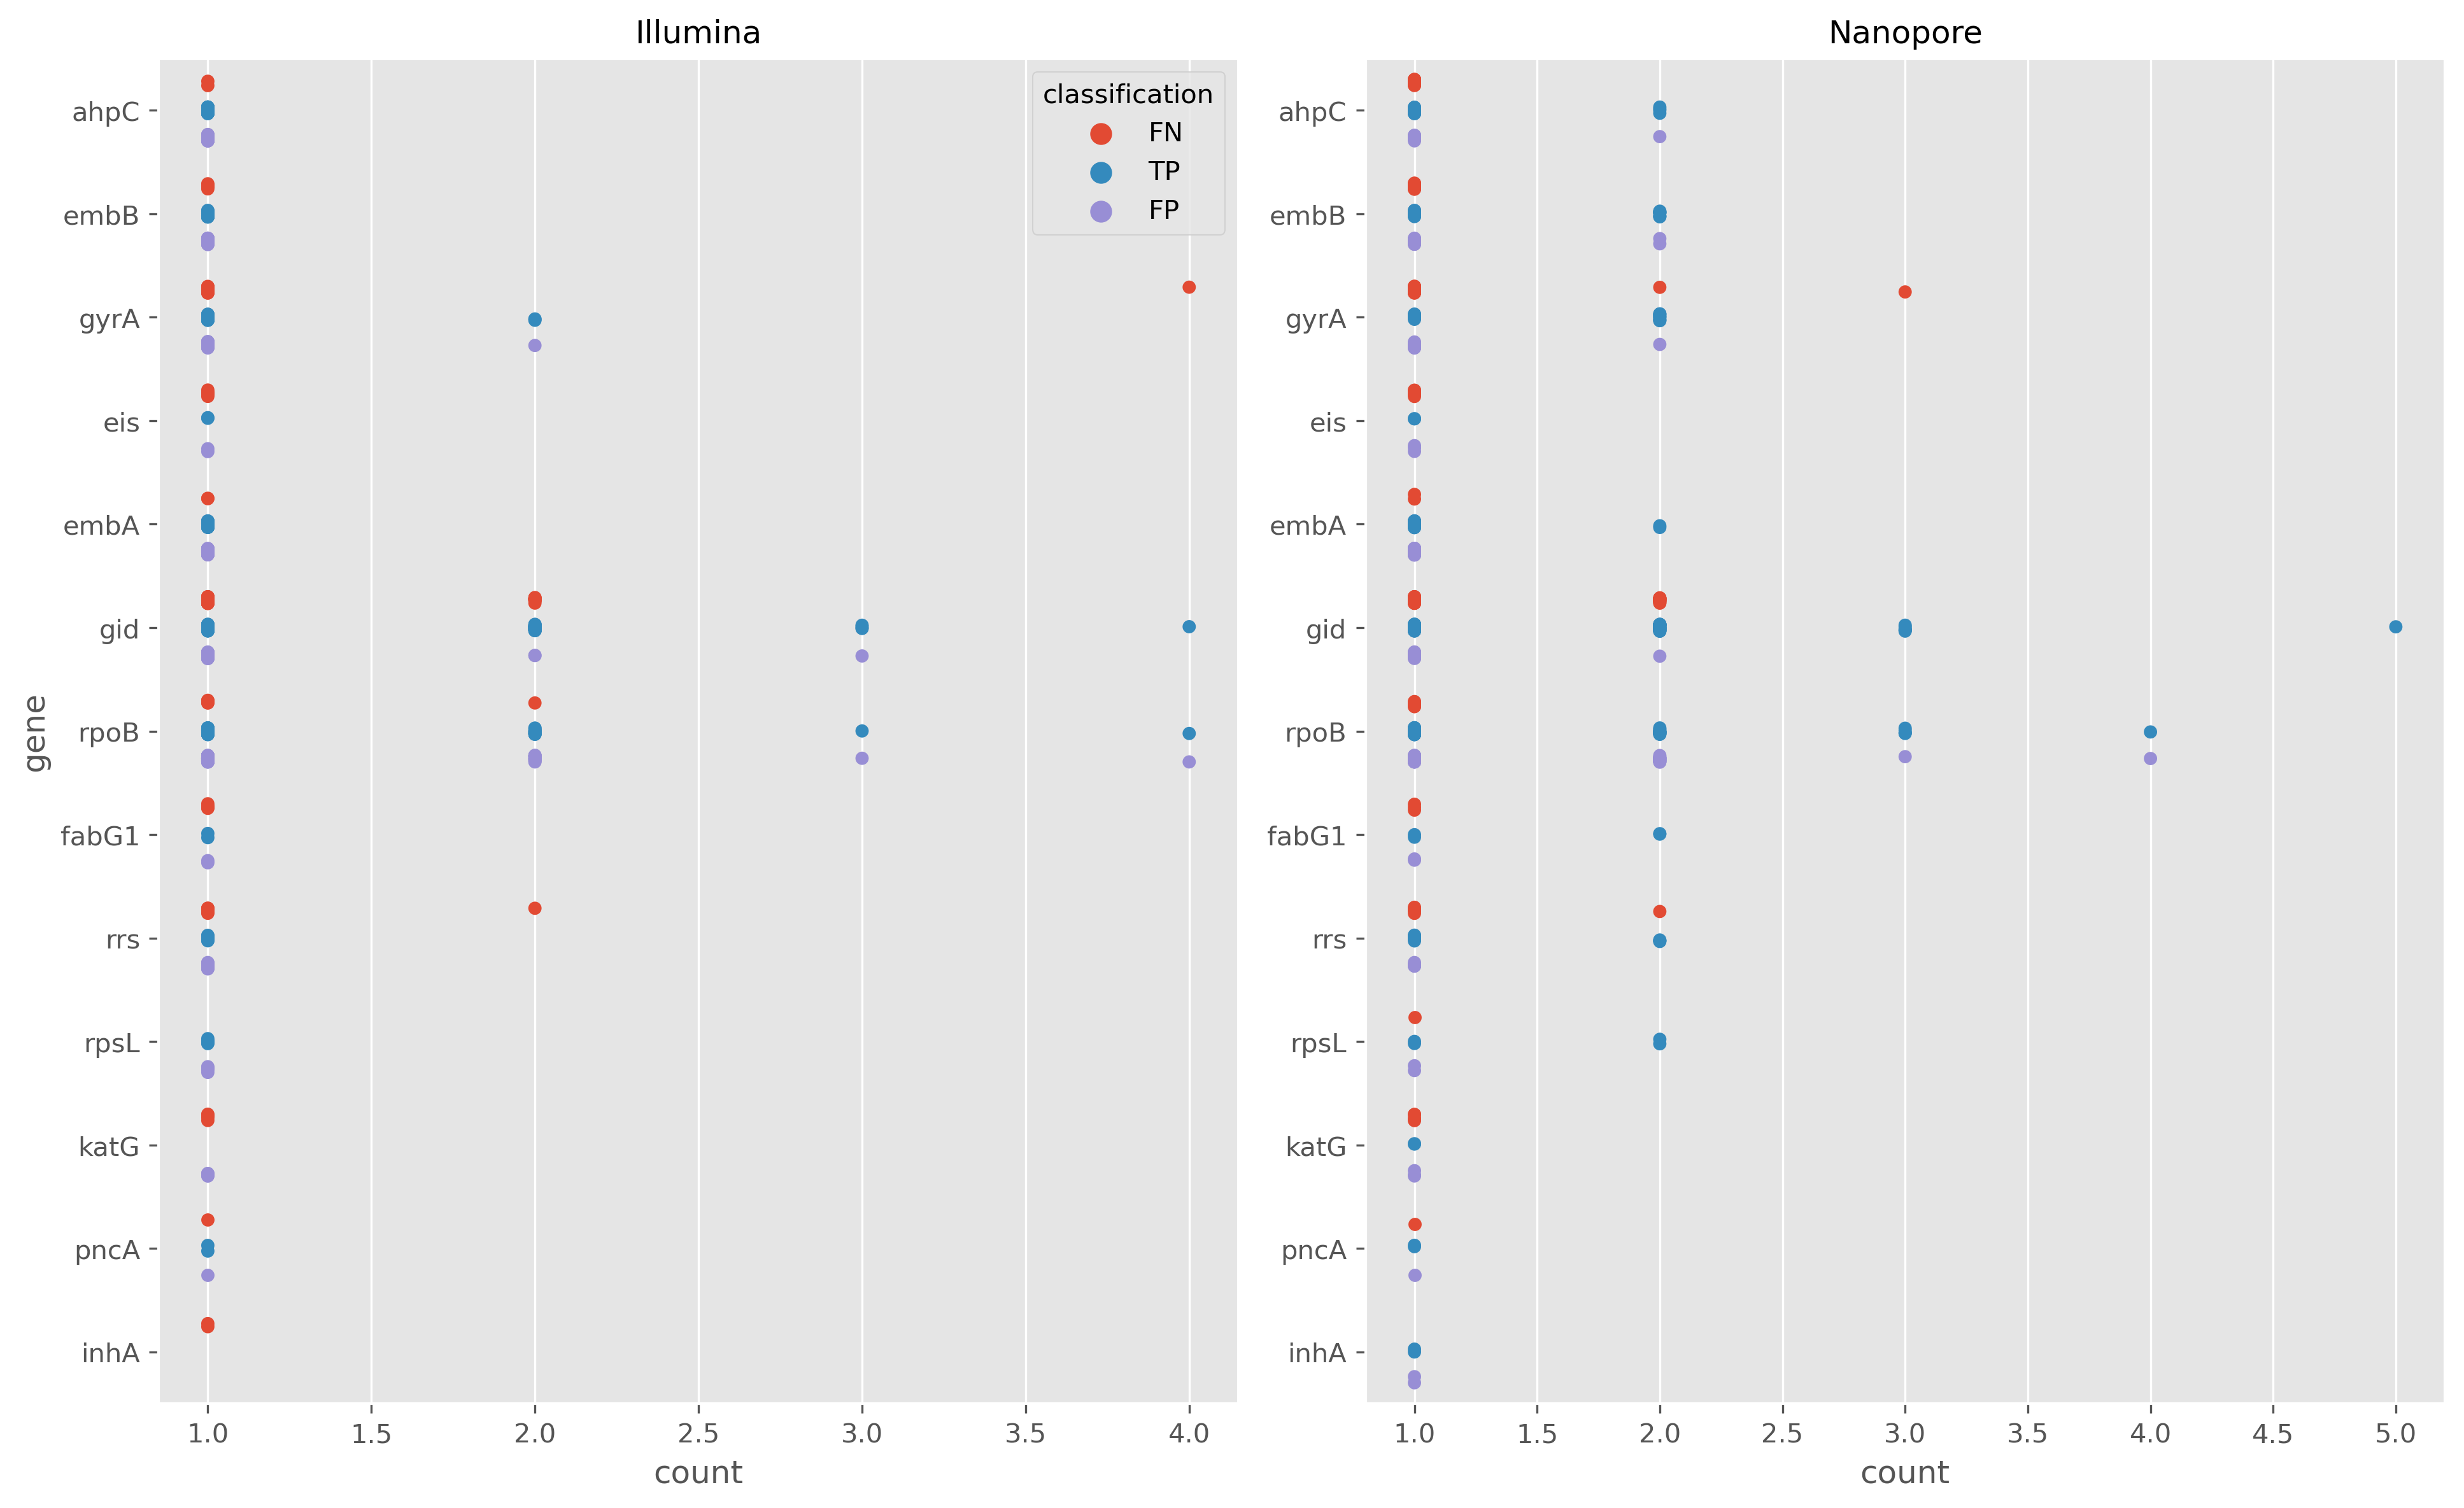

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.stripplot(data=g.query("tech==@tech"), dodge=True,hue="classification", y="gene", ax=ax, hue_order=hue_order, x="count")
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [38]:
df.groupby(["tech"])["is_indel"].describe()

,count,unique,top,freq
tech,,,,
illumina,561,1,False,561
nanopore,561,1,False,561
